In [4]:
EXPERIMENT_NUMBER = 13

In [6]:
import os
import cv2
import numpy as np
from pathlib import Path
from PIL import Image
import statistics
import pandas as pd

GT_PROB = 0.7

labeled_dir = str("/home/eric/Documents/cervicalResearchIIP/img_1006t/testLabel")

result_test_path = "/home/eric/Documents/cervicalResearchIIP/result_test/abstractresult/thorough/unet1x1/20241029-Conv1x1-" + str(EXPERIMENT_NUMBER)



from plotImg import plot_images
def plot_label_image(plot_output_img, path = 'None'):
     plot_img = []
     for output_img in plot_output_img:
          labels = np.unique(output_img)
          image = np.ones((255, 255, 3), dtype=np.uint8) * 0
          for x in range(255):
               for y in range(255):
                    # Get the pixel value (brightness)
                    pixel = output_img[x][y]
                    #  print(type(output_img))
                    if pixel == labels[0]:
                         image[x, y] = [0,0,0]
                    elif pixel == labels[1]:
                         image[x, y] = [2, 247, 68]
                    elif pixel == labels[2]:
                         image[x, y] = [255, 0, 38]
                    elif pixel == labels[3]:
                         image[x, y] = [234, 5, 250]
                    elif pixel == labels[4]:
                         image[x, y] = [21, 0, 255]
                    elif pixel == labels[5]:
                         image[x, y] = [0, 220, 245]
                    elif pixel == labels[6]:
                         image[x, y] = [205, 240, 7]
                    elif pixel == labels[7]:
                         image[x, y] = [255, 98, 0]
                    elif pixel == labels[8]:
                         image[x, y] = [0, 174, 255]
                    elif pixel == labels[9]:
                         image[x, y] = [255, 0, 174]
                    elif pixel == labels[10]:
                         image[x, y] = [198, 119, 74]
                    else:
                         print("There are more labels!")
          plot_img.append(image)
     plot_images(path, plot_img)



/home/eric/Documents/cervicalResearchIIP/result_test/abstractresult/thorough/unet1x1/20241029-Conv1x1-13
['oN4']
oN4-6.png
oN4-9.png
oN4-4.png
oN4-8.png
oN4-1.png
oN4-3.png
oN4-5.png
oN4-2.png
oN4-7.png
Loaded 9 images.
Shape of the first image: (256, 256)
[ 0  1  2  3  4  5  6  7  8  9 10]


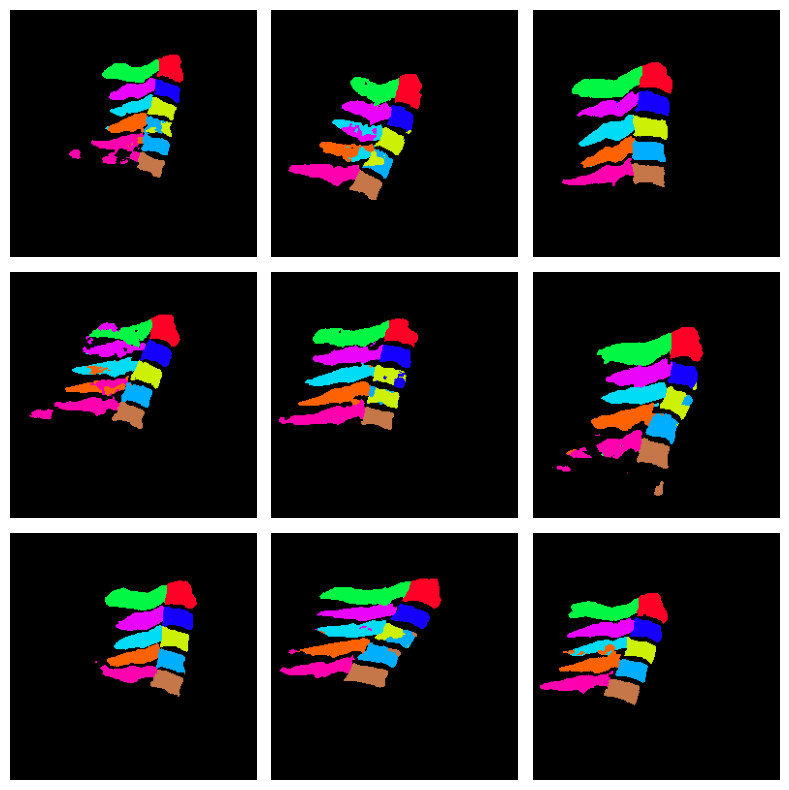

In [7]:

images_label_gray = []
crf_file_names = []
print(result_test_path)

TEST = []
TEST.append(os.listdir(result_test_path)[0][:3])
print(TEST)
for filename in os.listdir(result_test_path):
    # Check if the file is a PNG image
    if filename.endswith('.png'):
        if filename.startswith("oN"):
            # Construct the full file path
            print(filename)
            crf_file_names.append(filename)
            file_path = os.path.join(result_test_path, filename)
            # Read the image using OpenCV
            img = cv2.imread(file_path)
            if img is not None:
                #images.append(img) color
                img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                images_label_gray.append(img_gray)  # Append the grayscale image
            else:
                print(f"Failed to read image: {file_path}")

# Now `images` contains all the loaded PNG images
print(f"Loaded {len(images_label_gray)} images.")

if images_label_gray:
    print(f"Shape of the first image: {images_label_gray[0].shape}")  # This will show the dimensions of the image
print(np.unique(images_label_gray))
plot_label_image(images_label_gray)


(256, 256)
[ 0  1  2  3  4  5  6  7  8  9 10]
All labels are within the valid range (0 to 10).
(256, 256)
[ 0  1  2  3  4  5  6  7  8  9 10]
All labels are within the valid range (0 to 10).
(256, 256)
[ 0  1  2  3  4  5  6  7  8  9 10]
All labels are within the valid range (0 to 10).
(256, 256)
[ 0  1  2  3  4  5  6  7  8  9 10]
All labels are within the valid range (0 to 10).
(256, 256)
[ 0  1  2  3  4  5  6  7  8  9 10]
All labels are within the valid range (0 to 10).
(256, 256)
[ 0  1  2  3  4  5  6  7  8  9 10]
All labels are within the valid range (0 to 10).
(256, 256)
[ 0  1  2  3  4  5  6  7  8  9 10]
All labels are within the valid range (0 to 10).
(256, 256)
[ 0  1  2  3  4  5  6  7  8  9 10]
All labels are within the valid range (0 to 10).
(256, 256)
[ 0  1  2  3  4  5  6  7  8  9 10]
All labels are within the valid range (0 to 10).


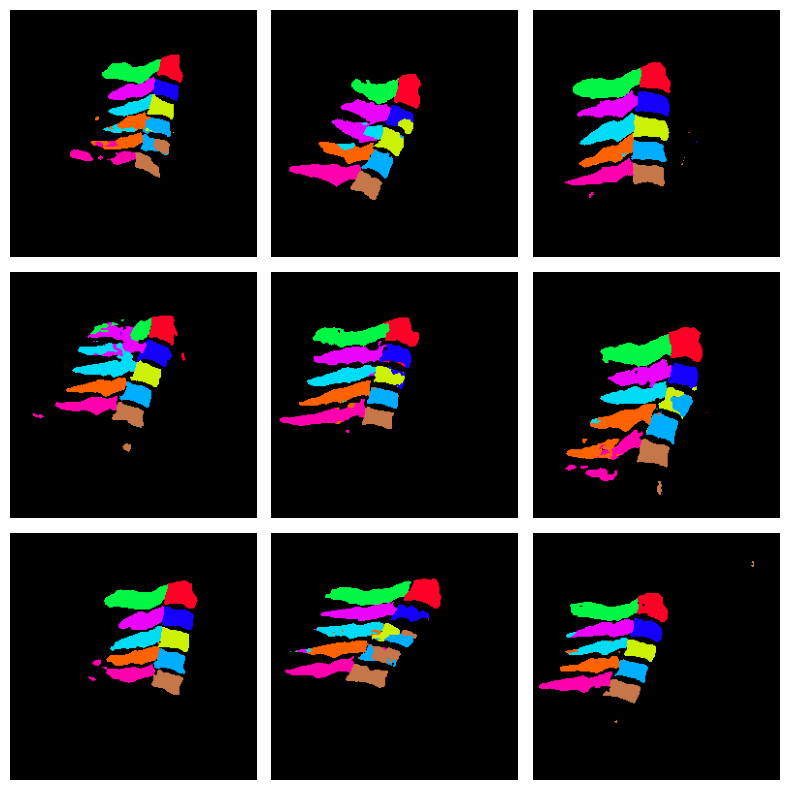

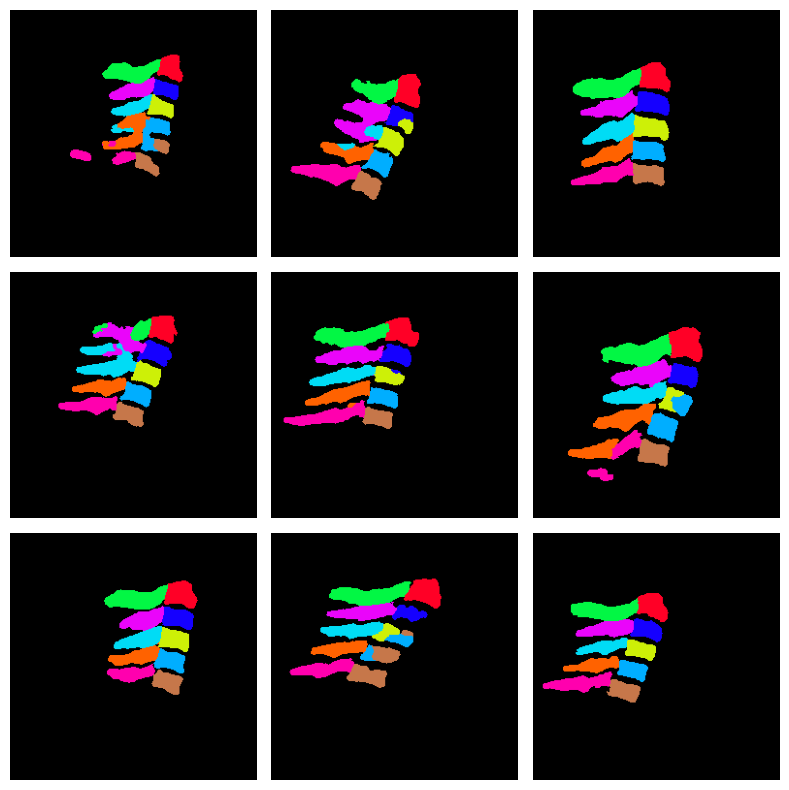

In [4]:
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_labels, create_pairwise_gaussian


# Segmentation output from U-Net (predicted image)
images_label_gray = np.array(images_label_gray)
#labels = images_label_gray[5]
refined_labels = []
for image_label_gray in images_label_gray:
    print(image_label_gray.shape)



    H, W = image_label_gray.shape
    image_label_gray = image_label_gray.flatten()

    print(np.unique(image_label_gray))

    invalid_indices = np.where((image_label_gray < 0) | (image_label_gray > 10))

    # Check if there are any invalid indices
    if invalid_indices[0].size > 0:
        print("Invalid label indices:", invalid_indices[0])  # Print the flat indices of invalid labels
        print("Invalid label values:", image_label_gray[invalid_indices])  # Print the invalid label values
    else:
        print("All labels are within the valid range (0 to 10).")


    # Create a dense CRF model
    num_classes = 11  # 0 to 10, so 11 classes
    d = dcrf.DenseCRF2D(W, H, num_classes)  # (width, height, num_classes)

    # Create unary potentials
    unary = unary_from_labels(image_label_gray, n_labels = num_classes, gt_prob = GT_PROB, zero_unsure = False)
    d.setUnaryEnergy(unary)

    # Add pairwise terms (spatial & appearance smoothness)
    d.addPairwiseGaussian(sxy=3, compat=10)

    # Inference
    Q = d.inference(5)  # Perform 5 CRF iterations

    # Convert Q into a label image
    refined_label = np.argmax(Q, axis=0)  # Most probable class for each pixel

    # Reshape back to the original image shape
    refined_label = refined_label.reshape((H, W))
    refined_labels.append(np.array(refined_label))


preCRF = images_label_gray
postCRF = refined_labels


plot_label_image(preCRF)
plot_label_image(postCRF)

# the plotting is not in order by the filename fix it!

In [5]:
# Saving the crf enhanced images into crf dir

# Create the crftestdir path
crftestdir = result_test_path + "/crf"
# Convert to Path object for easier manipulation
crftestdir_path = Path(crftestdir)

# Create the crf directory if it does not exist
if not crftestdir_path.exists():
    crftestdir_path.mkdir(parents=True, exist_ok=True)

# Convert the array to uint8 type if necessary
for index, refined_label in enumerate(refined_labels):
    refined_label_uint8 = refined_label.astype(np.uint8)
    # Create a PIL image from the NumPy array
    image = Image.fromarray(refined_label_uint8)
    # Save the crf refined images to the specified crf folder
    image.save(crftestdir_path / crf_file_names[index])  # Use / for path concatenation



In [6]:
def cal_DiceMulitple(dir, input_name):
    # change the label count as your preference
    Dice = [0] * 11
    Count1 = [0] * 11 #予測結果の各ラベルの要素数
    Count2 = [0] * 11 #ラベル画像の
    Count3 = [0] * 11 #正解した画素数
    
    for index in range(len(input_name)):
        print('index = ', index)

        img1 = cv2.imread(dir + '/' + input_name[index] + ".png", cv2.IMREAD_GRAYSCALE)
        img2 = cv2.imread(labeled_dir + '/' + input_name[index] + ".png", cv2.IMREAD_GRAYSCALE)
        #_, img2 = cv2.threshold(img2, 0, 255, cv2.THRESH_BINARY)
        print("予測画像:", dir  + '/' + input_name[index] + ".png")
        print("テストラベル:", labeled_dir + '/' + input_name[index] + ".png")
        unique_label1 = np.unique(img1)
        unique_label2 = np.unique(img2)
        # print(unique_label1)
        # print(unique_label2)
        # change the image array size to your need
        for n in range(256):
            for l in range(256):
                value1 = img1[n,l]
                # for index, uq_value in enumerate(unique_label1):
                #     if(value1 == uq_value):
                #         value1 = index

                Count1[value1] += 1

                value2 = img2[n,l]
                Count2[value2] += 1                    

                if(value1 == value2):
                    Count3[value1] += 1 
    for i in range(11):
        if(Count1[i]+Count2[i] != 0):
            Dice[i] = (2*Count3[i])/(Count1[i] + Count2[i])
        if(Count1[i]+Count2[i] == 0):
            print("")
            #print("4 label case:" + str(input_name[index]))
    Dice.append(statistics.mean(Dice[1:]))
    print('Count1 = ', Count1)
    print('Count2 = ', Count2)
    print('Count3 = ', Count3)
    print('Dice = ', Dice)
    #print(unique_label)

    return Dice

In [7]:
def file_names_with_prefix(directory_path, prefix):

    # Initialize an empty list to store the file names without extensions
    file_names_without_extension = []

    # Loop through all files in the specified directory
    for filename in os.listdir(directory_path):
        #Checking if the file in loop exists in the directory_path not sure how is this necessary
        #??
        if os.path.isfile(os.path.join(directory_path, filename)):
            # Check if the file name starts with the specified prefix
            if filename.startswith(prefix):
                # Get the file name without extension
                name_without_extension, _ = os.path.splitext(filename)

                # Append the file name (without extension) to the list
                file_names_without_extension.append(name_without_extension)

    # Sort the list of file names without extensions in ascending order
    sorted_file_names = sorted(
        file_names_without_extension,
        key=lambda x: (x.split('-')[0], int(x.split('-')[1]))
    )  # Modify this part based on your file naming convention

    # Now you have a sorted list of file names with the specified prefix and without extensions
    return sorted_file_names

In [ ]:
preCRFdir = result_test_path
postCRFdir = crftestdir

imgs_namepre = []
imgs_namepost = []

# TEST = ["oN4"]

##for single image
#imgs_namepre.append('oN4-1')
#imgs_namepost.append('oN4-1')


    
for pre_name in TEST:
    imgs_namepre.extend(file_names_with_prefix(preCRFdir, pre_name))
    
    
    
for post_name in TEST:
    imgs_namepost.extend(file_names_with_prefix(postCRFdir, post_name))

print(imgs_namepre)
print(imgs_namepost)

print("Pre CRF results:")
Dice = cal_DiceMulitple(preCRFdir, imgs_namepre)
df = pd.DataFrame(Dice)
df = df.T

print("Post CRF results:")
Dice = cal_DiceMulitple(postCRFdir, imgs_namepost)
df = pd.DataFrame(Dice)
df = df.T
df.to_csv(postCRFdir + "/CRFDice.csv", mode='a', header=False)

#plot_label_image(postCRF, postCRFdir)


['oN4-1', 'oN4-2', 'oN4-3', 'oN4-4', 'oN4-5', 'oN4-6', 'oN4-7', 'oN4-8', 'oN4-9']
['oN4-1', 'oN4-2', 'oN4-3', 'oN4-4', 'oN4-5', 'oN4-6', 'oN4-7', 'oN4-8', 'oN4-9']
Pre CRF results:
index =  0
予測画像: /home/eric/Documents/cervicalResearchIIP/result_test/abstractresult/thorough/unetconvmultip/20241029-Conv1x1-26/oN4-1.png
テストラベル: /home/eric/Documents/cervicalResearchIIP/img_1006t/testLabel/oN4-1.png
index =  1
予測画像: /home/eric/Documents/cervicalResearchIIP/result_test/abstractresult/thorough/unetconvmultip/20241029-Conv1x1-26/oN4-2.png
テストラベル: /home/eric/Documents/cervicalResearchIIP/img_1006t/testLabel/oN4-2.png
index =  2
予測画像: /home/eric/Documents/cervicalResearchIIP/result_test/abstractresult/thorough/unetconvmultip/20241029-Conv1x1-26/oN4-3.png
テストラベル: /home/eric/Documents/cervicalResearchIIP/img_1006t/testLabel/oN4-3.png
index =  3
予測画像: /home/eric/Documents/cervicalResearchIIP/result_test/abstractresult/thorough/unetconvmultip/20241029-Conv1x1-26/oN4-4.png
テストラベル: /home/eric/Documen